# Spotify Proof of Concept
## Abbie Tolon & Taylor Thomas
### April 29, 2022

First, import the necessary libraries

In [22]:
# Load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dataframe_image as dfi
import psycopg2
import warnings
warnings.filterwarnings('ignore')

#from at_password import password
#from tt_password import password

Read the file and examine the data

In [23]:
# Import Spotify csv file
spotify = pd.read_csv("Spotify 2010 - 2019 Top 100.csv")

# View data
spotify.tail() # It appears that our file loaded in 3 empty rows; we will remove those later

title            artist  \
998                 Strike a Pose (feat. Aitch)  Young T & Bugsey   
999   The London (feat. J. Cole & Travis Scott)        Young Thug   
1000                                        NaN               NaN   
1001                                        NaN               NaN   
1002                                        NaN               NaN   

        top genre  year released       added    bpm  nrgy  dnce   dB  live  \
998     afroswing         2019.0  2020‑08‑20  138.0  58.0  53.0 -6.0  10.0   
999   atl hip hop         2019.0  2020‑06‑22   98.0  59.0  80.0 -7.0  13.0   
1000          NaN            NaN         NaN    NaN   NaN   NaN  NaN   NaN   
1001          NaN            NaN         NaN    NaN   NaN   NaN  NaN   NaN   
1002          NaN            NaN         NaN    NaN   NaN   NaN  NaN   NaN   

       val    dur  acous  spch   pop  top year artist type  
998   59.0  214.0    1.0  10.0  67.0    2019.0         Duo  
999   18.0  200.0    2.0  15.0  75.0    2019.0        Solo  
1000   NaN    NaN    NaN   NaN   NaN       NaN         NaN  
1001   NaN    NaN    NaN   NaN   NaN       NaN         NaN  
1002   NaN    NaN    NaN   NaN   NaN       NaN         NaN

## Data Profile 

Now that we have loaded the file, we can begin understanding our data and what must be done to clean it

In [24]:
rows = len(spotify.index)
cols = len(spotify.columns)
print(f'Our Spotify data set currently contains {rows} rows and {cols} columns')

Our Spotify data set currently contains 1003 rows and 17 columns


In [25]:
# View data types and check null values
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          1000 non-null   object 
 1   artist         1000 non-null   object 
 2   top genre      1000 non-null   object 
 3   year released  1000 non-null   float64
 4   added          1000 non-null   object 
 5   bpm            1000 non-null   float64
 6   nrgy           1000 non-null   float64
 7   dnce           1000 non-null   float64
 8   dB             1000 non-null   float64
 9   live           1000 non-null   float64
 10  val            1000 non-null   float64
 11  dur            1000 non-null   float64
 12  acous          1000 non-null   float64
 13  spch           1000 non-null   float64
 14  pop            1000 non-null   float64
 15  top year       1000 non-null   float64
 16  artist type    1000 non-null   object 
dtypes: float64(12), object(5)
memory usage: 133.3+ KB


**Summarize Data, Overall in Table Format**

Next, we organize the information from above into a cleaner, more readable table

In [26]:
# Empty dictionary
spotify_info = dict()

# Iterate through the columns, to find nulls, counts, unique, and data types
for var in spotify.columns:
    summary = {'null_count':spotify[var].isnull().sum(),
                    'total_count':spotify[var].count(),
                    'unique_vals':spotify[var].nunique(),
                    'data_type':spotify[var].dtypes}
    # Update dictionary with the summary for each variables
    spotify_info.update({var:summary})

In [27]:
# Convert the dictionary from above into a data frame
spotify_info = pd.DataFrame(spotify_info).T
# set style
spotify_info_summary = spotify_info.style.set_table_attributes("style='display:inline'").set_caption('Spotify Data Summary') # view tables
# save data table
dfi.export(spotify_info_summary,"data_profile/spotify_data_summary.png")
spotify_info_summary

**Separate Categorical vs. Numeric Data**

Now that we have a good overall picture, we can separate categorical from numeric to have a better view

In [28]:
# Separate columns into object vs. numeric
numeric_cols = []
object_cols = []

# Iterate through spotify columns
for var in spotify.columns:
    # Check to see if the variable is NOT an object
    if spotify[var].dtypes != "O":
        # append to blank list
        numeric_cols.append(var)
    else:
        object_cols.append(var)

**Describe Categorical Data**

In [29]:
# Separate objects into new df
spotify_obj = spotify[object_cols].describe().T
# View data descriptions
spotify_obj.style.set_table_attributes("style='display:inline'").set_caption('Summary of Categorical Variables')

**Describe Numeric Data**

In [30]:
# Separate numeric into new df
spotify_num = spotify[numeric_cols].describe().T
# view data descriptions
spotify_num_summary = spotify_num.style.set_table_attributes("style='display:inline'").set_caption('Summary of Numeric Variables')

#save data table
dfi.export(spotify_num_summary, "data_profile/spotify_num_summary.png")
spotify_num_summary

**Find the Top 5 Values for Numeric Data**

We have the numeric data currently separated. We can use this subset to view the top 5 ranks per variable

In [35]:
spotify_num = spotify[numeric_cols].describe()

# Empty dictionary
top_list = dict()

# Iterate through the columns, sort, find top 5, and update dictionary
for var in spotify_num.columns:
    top_5 = spotify[var].sort_values(ascending=False).head(5).tolist()
    top_list.update({var:top_5})

In [36]:
# Convert dictionary to data frame
top_5df = pd.DataFrame(top_list)
# Drop year columns because they don't make sense contextually
top_5df = top_5df.drop(['year released', 'top year'], axis=1)
# Rename the index
top_5df.index.name = 'Rank'
# Start index from 1
top_5df.index +=1
top_5_summary = top_5df.style.set_table_attributes("style='display:inline'").set_caption('Top 5 Values for Numeric Features') # view results
#save data table
dfi.export(top_5_summary, "data_profile/top_5_summary.png")
top_5_summary

## Assess the Data

Overall, the data is high quality and requires only minimal cleaning. There are no *actual* missing values. However, the csv file imported 3 extra blank rows, so we need to remove them. We have 17 features, 5 of which are object type, and the rest are floats. 

Here are some of the following data cleaning steps we will take: 
- Convert the "year released" and "top year" features to be an integer, rather than a float
- Remove unnecessary columns (added) because that doesn't add anything to our analysis
- Remove the spaces from column names and replace with underscore
- Remove the commas from "artist" and "title" fields
- Create a usable song_ID variable

## Cleaning the Data

**Remove the NaN blank rows**

In [3]:
# Drop the blank entries
spotify_df = spotify.dropna()
spotify_df.tail() # confirmed our blank entries are gone

title              artist  \
995                                 SICKO MODE        Travis Scott   
996                                  EARFQUAKE  Tyler, The Creator   
997                  Boasty (feat. Idris Elba)               Wiley   
998                Strike a Pose (feat. Aitch)    Young T & Bugsey   
999  The London (feat. J. Cole & Travis Scott)          Young Thug   

       top genre  year released       added    bpm  nrgy  dnce   dB  live  \
995      hip hop         2018.0  2020‑06‑22  155.0  73.0  83.0 -4.0  12.0   
996      hip hop         2019.0  2020‑06‑22   80.0  50.0  55.0 -9.0  80.0   
997        grime         2019.0  2020‑06‑22  103.0  77.0  89.0 -5.0   9.0   
998    afroswing         2019.0  2020‑08‑20  138.0  58.0  53.0 -6.0  10.0   
999  atl hip hop         2019.0  2020‑06‑22   98.0  59.0  80.0 -7.0  13.0   

      val    dur  acous  spch   pop  top year artist type  
995  45.0  313.0    1.0  22.0  86.0    2019.0        Solo  
996  41.0  190.0   23.0   7.0  85.0    2019.0        Solo  
997  46.0  177.0    1.0   7.0  68.0    2019.0        Solo  
998  59.0  214.0    1.0  10.0  67.0    2019.0         Duo  
999  18.0  200.0    2.0  15.0  75.0    2019.0        Solo

In [222]:
print(f' We now have {len(spotify_df.index)} rows, which is correct')

 We now have 1000 rows, which is correct


**Convert the year features to integer**

In [4]:
spotify_df['year released'] = spotify_df['year released'].apply(lambda row: int(row))
spotify_df['top year'] = spotify_df['top year'].apply(lambda row: int(row))
spotify_df.head()

title      artist    top genre  \
0                  STARSTRUKK (feat. Katy Perry)       3OH!3    dance pop   
1                    My First Kiss (feat. Ke$ha)       3OH!3    dance pop   
2                                I Need A Dollar  Aloe Blacc     pop soul   
3  Airplanes (feat. Hayley Williams of Paramore)       B.o.B  atl hip hop   
4              Nothin' on You (feat. Bruno Mars)       B.o.B  atl hip hop   

   year released       added    bpm  nrgy  dnce   dB  live   val    dur  \
0           2009  2022‑02‑17  140.0  81.0  61.0 -6.0  23.0  23.0  203.0   
1           2010  2022‑02‑17  138.0  89.0  68.0 -4.0  36.0  83.0  192.0   
2           2010  2022‑02‑17   95.0  48.0  84.0 -7.0   9.0  96.0  243.0   
3           2010  2022‑02‑17   93.0  87.0  66.0 -4.0   4.0  38.0  180.0   
4           2010  2022‑02‑17  104.0  85.0  69.0 -6.0   9.0  74.0  268.0   

   acous  spch   pop  top year artist type  
0    0.0   6.0  70.0      2010         Duo  
1    1.0   8.0  68.0      2010         Duo  
2   20.0   3.0  72.0      2010        Solo  
3   11.0  12.0  80.0      2010        Solo  
4   39.0   5.0  79.0      2010        Solo

**Remove unnecessary column**

In [5]:
# Remove "added" which is our unnecessary column
spotify_df = spotify_df.drop("added", axis=1)
spotify_df

title              artist  \
0                    STARSTRUKK (feat. Katy Perry)               3OH!3   
1                      My First Kiss (feat. Ke$ha)               3OH!3   
2                                  I Need A Dollar          Aloe Blacc   
3    Airplanes (feat. Hayley Williams of Paramore)               B.o.B   
4                Nothin' on You (feat. Bruno Mars)               B.o.B   
..                                             ...                 ...   
995                                     SICKO MODE        Travis Scott   
996                                      EARFQUAKE  Tyler, The Creator   
997                      Boasty (feat. Idris Elba)               Wiley   
998                    Strike a Pose (feat. Aitch)    Young T & Bugsey   
999      The London (feat. J. Cole & Travis Scott)          Young Thug   

       top genre  year released    bpm  nrgy  dnce   dB  live   val    dur  \
0      dance pop           2009  140.0  81.0  61.0 -6.0  23.0  23.0  203.0   
1      dance pop           2010  138.0  89.0  68.0 -4.0  36.0  83.0  192.0   
2       pop soul           2010   95.0  48.0  84.0 -7.0   9.0  96.0  243.0   
3    atl hip hop           2010   93.0  87.0  66.0 -4.0   4.0  38.0  180.0   
4    atl hip hop           2010  104.0  85.0  69.0 -6.0   9.0  74.0  268.0   
..           ...            ...    ...   ...   ...  ...   ...   ...    ...   
995      hip hop           2018  155.0  73.0  83.0 -4.0  12.0  45.0  313.0   
996      hip hop           2019   80.0  50.0  55.0 -9.0  80.0  41.0  190.0   
997        grime           2019  103.0  77.0  89.0 -5.0   9.0  46.0  177.0   
998    afroswing           2019  138.0  58.0  53.0 -6.0  10.0  59.0  214.0   
999  atl hip hop           2019   98.0  59.0  80.0 -7.0  13.0  18.0  200.0   

     acous  spch   pop  top year artist type  
0      0.0   6.0  70.0      2010         Duo  
1      1.0   8.0  68.0      2010         Duo  
2     20.0   3.0  72.0      2010        Solo  
3     11.0  12.0  80.0      2010        Solo  
4     39.0   5.0  79.0      2010        Solo  
..     ...   ...   ...       ...         ...  
995    1.0  22.0  86.0      2019        Solo  
996   23.0   7.0  85.0      2019        Solo  
997    1.0   7.0  68.0      2019        Solo  
998    1.0  10.0  67.0      2019         Duo  
999    2.0  15.0  75.0      2019        Solo  

[1000 rows x 16 columns]

**Clean up the column names**

In [6]:
# Change columns to not have any spaces
# Make variable names more descriptive

spotify_df.rename(columns = {'title':'song_title', 
                             'top genre':'genre',
                              'year released':'year_released',
                              'nrgy':'energy',
                              'dnce':'danceability',
                              'dB':'decibels',
                               'val':'positivity',
                              'dur':'song_length',
                             'acous':'how_acoustic',
                             'spch':'how_spoken',
                             'pop':'popularity',
                             'top year':'top_year',
                             'artist type':'artist_type'
                              }, inplace = True)

spotify_df.columns

Index(['song_title', 'artist', 'genre', 'year_released', 'bpm', 'energy',
       'danceability', 'decibels', 'live', 'positivity', 'song_length',
       'how_acoustic', 'how_spoken', 'popularity', 'top_year', 'artist_type'],
      dtype='object')

**Remove unwanted commas**

In [7]:
# Replace the commas with empty spaces so that postgres takes it
spotify_df['artist'] = spotify_df['artist'].apply(lambda x: x.replace(',',''))
spotify_df['song_title'] = spotify_df['song_title'].apply(lambda x: x.replace(',',''))

## Prepare for ETL

**Create a song_ID for primary key**

Each entry in the data set is unique. However, we cannot use "song_title" as the primary key because there are duplicate song titles. A song by the same artist can also be in more than one "top year." Therefore, you would need to combine the title, artist, added, and top year in order to get the unique value. Rather than concatenating all of those into a new "ID" field, we thought it would be cleaner to just create a unique numeric ID for each entry. See code below.

In [12]:
# Need to create a songID that we can use for our primary key, since some song names are duplicates
spotify_df.reset_index(inplace=True)
spotify_df = spotify_df.rename(columns = {'index':'song_ID'})
spotify_df.head()

song_ID                                     song_title      artist  \
0        0                  STARSTRUKK (feat. Katy Perry)       3OH!3   
1        1                    My First Kiss (feat. Ke$ha)       3OH!3   
2        2                                I Need A Dollar  Aloe Blacc   
3        3  Airplanes (feat. Hayley Williams of Paramore)       B.o.B   
4        4              Nothin' on You (feat. Bruno Mars)       B.o.B   

         genre  year_released    bpm  energy  danceability  decibels  live  \
0    dance pop           2009  140.0    81.0          61.0      -6.0  23.0   
1    dance pop           2010  138.0    89.0          68.0      -4.0  36.0   
2     pop soul           2010   95.0    48.0          84.0      -7.0   9.0   
3  atl hip hop           2010   93.0    87.0          66.0      -4.0   4.0   
4  atl hip hop           2010  104.0    85.0          69.0      -6.0   9.0   

   positivity  song_length  how_acoustic  how_spoken  popularity  top_year  \
0        23.0        203.0           0.0         6.0        70.0      2010   
1        83.0        192.0           1.0         8.0        68.0      2010   
2        96.0        243.0          20.0         3.0        72.0      2010   
3        38.0        180.0          11.0        12.0        80.0      2010   
4        74.0        268.0          39.0         5.0        79.0      2010   

  artist_type  
0         Duo  
1         Duo  
2        Solo  
3        Solo  
4        Solo

**Create our two files, based on the tables we want**

**Artist file**

In [45]:
# Artist file creation
artist_df = spotify_df[['artist', 'genre', 'artist_type']]
artist_df.head()

artist        genre artist_type
0       3OH!3    dance pop         Duo
1       3OH!3    dance pop         Duo
2  Aloe Blacc     pop soul        Solo
3       B.o.B  atl hip hop        Solo
4       B.o.B  atl hip hop        Solo

In [46]:
# Delete duplicate artists, so that we have one unique row per artist, as our primary key
artist_df = artist_df.drop_duplicates('artist')
artist_df.head()

artist        genre artist_type
0            3OH!3    dance pop         Duo
2       Aloe Blacc     pop soul        Solo
3            B.o.B  atl hip hop        Solo
6  Black Eyed Peas    dance pop  Band/Group
8       Bruno Mars    dance pop        Solo

In [47]:
# Confirm that deleting duplicates ran appropriately
print(artist_df['artist'].nunique()) # artist df
print(spotify_df['artist'].nunique()) # original df

444
444


In [48]:
# write this to csv to load into postres through psycopg
artist_df.to_csv('artist.csv', index=False)

**Song file**

In [49]:
# Create the song file
song_df = spotify_df.drop(['artist', 'genre', 'artist_type'], axis=1)
song_df.head()

song_ID                                     song_title  year_released  \
0        0                  STARSTRUKK (feat. Katy Perry)           2009   
1        1                    My First Kiss (feat. Ke$ha)           2010   
2        2                                I Need A Dollar           2010   
3        3  Airplanes (feat. Hayley Williams of Paramore)           2010   
4        4              Nothin' on You (feat. Bruno Mars)           2010   

     bpm  energy  danceability  decibels  live  positivity  song_length  \
0  140.0    81.0          61.0      -6.0  23.0        23.0        203.0   
1  138.0    89.0          68.0      -4.0  36.0        83.0        192.0   
2   95.0    48.0          84.0      -7.0   9.0        96.0        243.0   
3   93.0    87.0          66.0      -4.0   4.0        38.0        180.0   
4  104.0    85.0          69.0      -6.0   9.0        74.0        268.0   

   how_acoustic  how_spoken  popularity  top_year  
0           0.0         6.0        70.0      2010  
1           1.0         8.0        68.0      2010  
2          20.0         3.0        72.0      2010  
3          11.0        12.0        80.0      2010  
4          39.0         5.0        79.0      2010

In [50]:
# write the song csv file
song_df.to_csv('song.csv', index=False)

## Spotify ETL

Now that our data are cleaned, we can perform the ETL. This will allow us to load our data into a relational database through postgres. In the following steps, we will create a new database for our tables. Then, we will create a "song" table and an "artsist" table.

### Create Spotify Database in Postgres

In [21]:
# Create connection to postgres
conn = psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password=password)

conn.autocommit = True

# set up cursor
cursor = conn.cursor()

# Create the spotify database
sql = '''CREATE database spotify''';

# Create a database
cursor.execute(sql)
print("Database was successfully created!")

# close the connection 
conn.close()

Database was successfully created!


In [147]:
# Create connection to postgres
conn = psycopg2.connect(host='localhost', dbname='spotify', user='postgres', password=password)
cursor = conn.cursor()

### Create the Song Table

**Empty Table for Song**

First, we create an empty song table, in which we will populate data

In [137]:
# Create the song table
# song_ID is our primary key

cursor.execute("""
            CREATE TABLE Song(
            SONG_ID integer PRIMARY KEY,
            SONG_TITLE text,
            YEAR_RELEASED integer,
            BPM float,
            ENERGY float,
            DANCEABILITY float,
            DECIBELS float,
            LIVE float,
            POSITIVITY float,
            SONG_LENGTH float,
            HOW_ACOUSTIC float,
            HOW_SPOKEN float,
            POPULARITY float,
            TOP_YEAR integer)
"""
)

conn.commit()

**Populate song table with data**

In [148]:
# open the csv file
with open('song.csv', encoding='utf8') as i:
    # skip header
    next(i)
    
    # call the song table we created
    cursor.copy_from(i, 'song', sep=',', null='')

conn.commit()
conn.close()

**Song Sample Query**

Perform a basic query, just to confirm our ETL worked

In [149]:
with psycopg2.connect(host='localhost', dbname='spotify', user='postgres', password=password) as conn:
    # create a query
    query1 = """SELECT * FROM song"""
    
    # read the query we made
    sample_query = pd.read_sql_query(query1, conn)

# Display our results
sample_query.head()

song_id                                     song_title  year_released  \
0        0                  STARSTRUKK (feat. Katy Perry)           2009   
1        1                    My First Kiss (feat. Ke$ha)           2010   
2        2                                I Need A Dollar           2010   
3        3  Airplanes (feat. Hayley Williams of Paramore)           2010   
4        4              Nothin' on You (feat. Bruno Mars)           2010   

     bpm  energy  danceability  decibels  live  positivity  song_length  \
0  140.0    81.0          61.0      -6.0  23.0        23.0        203.0   
1  138.0    89.0          68.0      -4.0  36.0        83.0        192.0   
2   95.0    48.0          84.0      -7.0   9.0        96.0        243.0   
3   93.0    87.0          66.0      -4.0   4.0        38.0        180.0   
4  104.0    85.0          69.0      -6.0   9.0        74.0        268.0   

   how_acoustic  how_spoken  popularity  top_year  
0           0.0         6.0        70.0      2010  
1           1.0         8.0        68.0      2010  
2          20.0         3.0        72.0      2010  
3          11.0        12.0        80.0      2010  
4          39.0         5.0        79.0      2010

### Create Artist Table

**Empty Table for Artist**

Next, create our artist table in postgres

In [23]:
# Create the artist table
# artist is our primary key

cursor.execute("""
            CREATE TABLE Artist(
            ARTIST text PRIMARY KEY,
            GENRE text,
            ARTIST_TYPE text)
""")

conn.commit()

**Populate artist table with data**

In [24]:
# open the saved csv file
with open('artist.csv', 'r') as i:
    # skip the header row
    next(i)
    
    # call the artist table that we created; comma delimited
    cursor.copy_from(i, 'artist', sep=',', null='')

conn.commit()
conn.close()

**Artist Sample Query**

In [141]:
with psycopg2.connect(host='localhost', dbname='spotify', user='postgres', password=password) as conn:
    # create a query
    query1 = """SELECT * FROM artist"""
    
    # read the query we made
    sample_query = pd.read_sql_query(query1, conn)

# Display our results
sample_query.head()

artist        genre artist_type
0            3OH!3    dance pop         Duo
1       Aloe Blacc     pop soul        Solo
2            B.o.B  atl hip hop        Solo
3  Black Eyed Peas    dance pop  Band/Group
4       Bruno Mars    dance pop        Solo

## Business Questions

Finally, we use our data to answer the following business questions.

### 1) Which year had the most popular songs?
### 2) Who were the top 10 artists overall? 
### 3) Has the average song duration decreased over time?

#### 1) Which year had the most popular songs?

In [8]:
# Set seaborn style to use throughout our visuals
sns.set_style("whitegrid")
# Set the color palette based on Spotify branding colors
colors = ['#6DE898', '#57E489', '#41E17A', '#2BDE6A', '#20CF5E', '#1DB954', '#1AA34A', '#168D40', '#137736', '#0F612C']

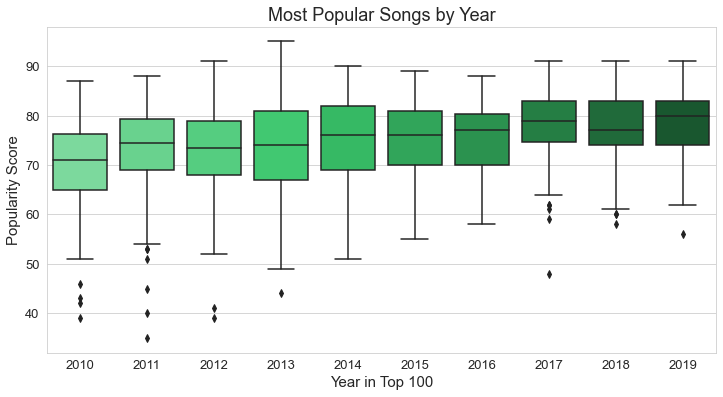

In [47]:
# Set our palette
sns.set_palette(sns.color_palette(colors))
# Set our figure size
plt.figure(figsize=[12,6])
# Create box plot
sns.boxplot(x="top_year", y="popularity", data=spotify_df)
plt.ylabel('Popularity Score', fontsize=15)
plt.xlabel('Year in Top 100', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Most Popular Songs by Year', fontsize=18)
# save figure to repo
plt.savefig('data_vis/boxplot_year_pop.png')
plt.show()

#### 2) Who were the top 10 artists overall? 

In [9]:
# Group by artist and aggregate by artist count (the total frequency they appear in our data set)
artist_group = spotify_df.groupby('artist').agg({'artist':'count'})
# Rename the column to avoid naming errors later
artist_group['total_artist'] = artist_group['artist']
# Drop the column called "artist" to avoid naming errors with the index
artist_group = artist_group.drop('artist', axis=1)

In [10]:
# View results to confirm 
artist_group.head()

total_artist
artist                           
2 Chainz                        2
21 Savage                       2
3OH!3                           2
5 Seconds of Summer             4
6ix9ine                         2

In [11]:
# Sort the artists in order to find the most popular (get 11, because there was a 4-way tie)
top_artists = artist_group.sort_values('total_artist', ascending=False).head(11)
# This step is to grab the proper index order for our lollipop chart
artist_sort = top_artists.sort_values('total_artist', ascending=True).reset_index()

In [12]:
# Create the range for our y-axis on the lollipop chart
my_range = range(1,len(artist_sort.index)+1)

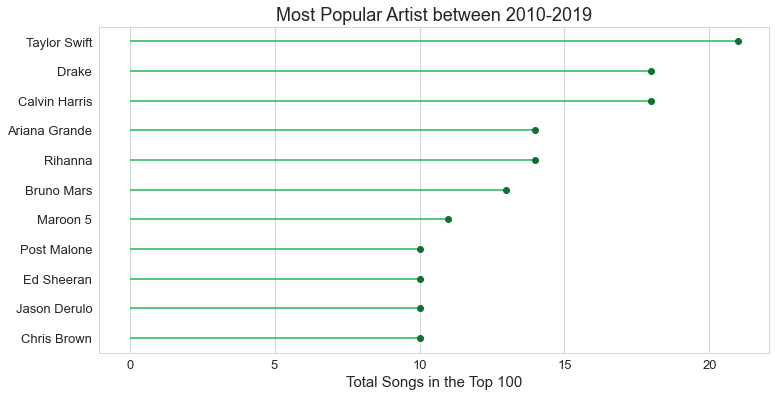

In [21]:
# Set figure size
plt.figure(figsize=[12,6])
# Set up proper gridlines
plt.hlines(y=my_range, xmin=0, xmax=artist_sort['total_artist'], color='#1DB954')
# Create the plot, and add 'o' mark for our circles 
plt.plot(artist_sort['total_artist'], my_range, 'o', color='#136e33')
plt.yticks(my_range, artist_sort['artist'], fontsize=13)
plt.xticks(fontsize=13)
plt.title('Most Popular Artist between 2010-2019', fontsize=18)
plt.xlabel('Total Songs in the Top 100', fontsize=15)
# only keep the y gridlines
plt.grid(axis='y')
# save figure to repo
plt.savefig('data_vis/lolipop_most_popular.png')
plt.show()

#### 3) Has the average song duration decreased over time?

In [19]:
# First, group by year and aggregate the average song length
song_duration = spotify_df.groupby('top_year').agg({'song_length':'mean'})
song_duration # view results

song_length
top_year             
2010           226.45
2011           230.19
2012           226.38
2013           229.49
2014           227.90
2015           218.46
2016           219.86
2017           221.04
2018           208.79
2019           195.50

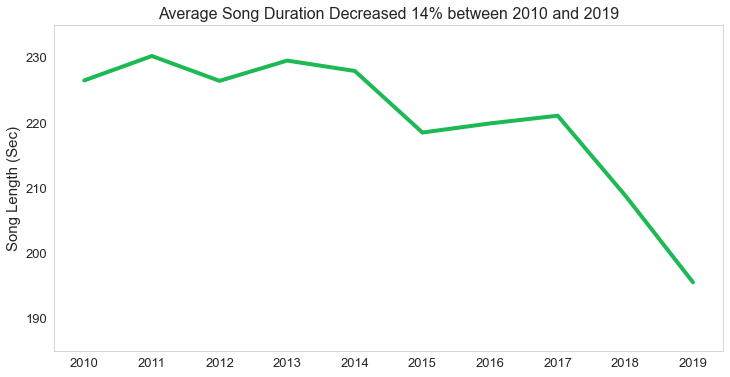

In [45]:
# set figure size
plt.figure(figsize=[12,6])
# create line plot
sns.lineplot(x='top_year', y='song_length', data=song_duration, linewidth=4, color='#1DB954')
plt.ylim(185,235)
plt.xlabel('')
plt.xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Song Length (Sec)', fontsize=15)
plt.grid(False)
plt.title('Average Song Duration Decreased 14% between 2010 and 2019', fontsize=16)
# save figure to repo
plt.savefig('data_vis/lineplot_average_song.png')
plt.show()